## 5.3 사전 훈련된 컨브넷 사용

In [16]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 데이터 증식을 사용하지 않는 빠른 특성 추출

### 코드 5-17 사전 훈련된 합성곱 기반 층을 사용한 특성 추출

In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "C:/datasets/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test' )

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_count:
            print (i)
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
    

Found 2000 images belonging to 2 classes.
100
Found 1000 images belonging to 2 classes.
50
Found 1000 images belonging to 2 classes.
50


추출된 feature의 크기는 (samples, 4, 4, 512)고, Fully Connected Network에 주입하기 위해 먼저 (samples, 8192) 크기로 펼침

In [19]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 코드 5-18 완전 연결 분류기를 정의하고 훈련

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6145 - acc: 0.6445 - val_loss: 0.4449 - val_acc: 0.8150
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4361 - acc: 0.7955 - val_loss: 0.3640 - val_acc: 0.8680
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3627 - acc: 0.8420 - val_loss: 0.3242 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3243 - acc: 0.8610 - val_loss: 0.3134 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2886 - acc: 0.8855 - val_loss: 0.2864 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2640 - acc: 0.8945 - val_loss: 0.2790 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2506 - acc: 0.9005 - val_loss: 0.2812 - val_acc: 0.8840
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 0.

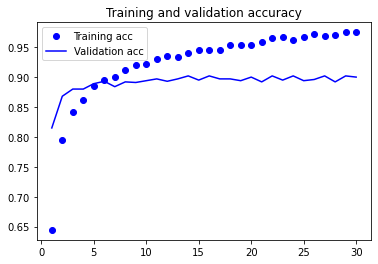

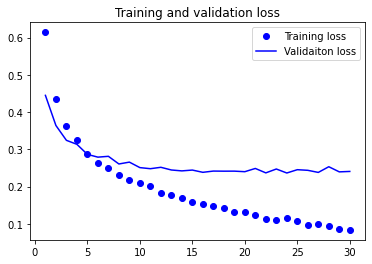

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaiton loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 데이터 증식을 사용한 Feature 추출

### 코드 5-20 합성곱 기반 층 위에 완전 연결 분류기 추가

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기 전 합성곱 기반 층을 동결하는 것이 아주 중요.<br>
동결 = 가중치 업데이트가 되지 않도록 막음<br>
동결하지 않을 경우 합성곱 기반 층에 의해 사전에 학습된 표현이 훈련하는 동안 수정 됨<br>
맨 위의 Dense 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파 => 사전 학습된 표현을 크게 훼손

In [24]:
print ('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [25]:
conv_base.trainable = False

In [26]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


위와 같이 설정할 경우 추가한 2개의 Dense 층의 가중치만 훈련 됨<br>
층마다 2개씩(가중ㅇ치 행렬과 편향 벡터) 총 4개의 텐서가 훈련됨<br>
변경 사항 적용은 모델을 컴파일해야함

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

# 검증 데이터는 증식되어서는 안됨!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size = 20,
    # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 11s 112ms/step - loss: 0.6129 - acc: 0.6595 - val_loss: 0.4824 - val_acc: 0.8030
Epoch 2/30
100/100 [==============================] - 11s 109ms/step - loss: 0.4850 - acc: 0.7805 - val_loss: 0.3783 - val_acc: 0.8520
Epoch 3/30
100/100 [==============================] - 11s 108ms/step - loss: 0.4429 - acc: 0.8060 - val_loss: 0.3358 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 11s 108ms/step - loss: 0.4011 - acc: 0.8230 - val_loss: 0.3069 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 11s 108ms/step - loss: 0.3889 - acc: 0.8185 - val_loss: 0.3025 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 11s 108ms/step - loss: 0.3565 - acc: 0.8420 - val_loss: 0.3046 - val_acc: 0.8770
Epoch 7/30
100/100 [==========

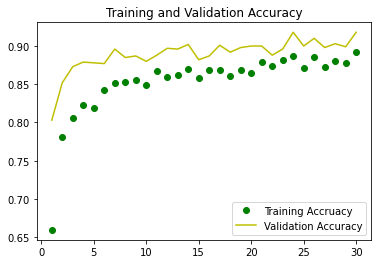

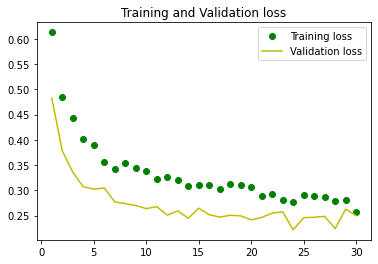

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epcohs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'go', label='Training Accruacy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### 5.3.2 미세 조정

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정임<br>
미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇개를 동결에서 해제하고<br>
모델에 새로 추가한 층(여기선 완전 연결 분류기)과 함께 훈련하는 것<br>
정확히는 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라 함

미세 조정 단계<br>
1. 사전 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 훈련
4. 기반 네트워크에서 일부 층의 동결을 해제
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련

In [29]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 코드 5-22 특정 층까지 모든 층 동결 (왜 block5_conv1만 동결 해제하는지 이해가 안가네)

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### 코드 5-23 모델 미세 조정 (steps_per_epoch는 데이터 증식할 때 필요)

In [31]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 11s 110ms/step - loss: 0.2852 - acc: 0.8755 - val_loss: 0.3770 - val_acc: 0.8490
Epoch 2/100
100/100 [==============================] - 11s 108ms/step - loss: 0.2532 - acc: 0.8935 - val_loss: 0.2092 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 11s 110ms/step - loss: 0.2293 - acc: 0.9060 - val_loss: 0.2064 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 11s 111ms/step - loss: 0.2358 - acc: 0.8980 - val_loss: 0.2256 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 11s 110ms/step - loss: 0.2114 - acc: 0.9170 - val_loss: 0.1958 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 11s 108ms/step - loss: 0.1846 - acc: 0.9260 - val_loss: 0.2025 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 11s 109ms/step - loss: 0.1922 - acc: 0.9210 - val_loss: 0.1699 - val_acc: 0.9320
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0328 - acc: 0.9880 - val_loss: 0.3231 - val_acc: 0.9290
Epoch 62/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0282 - acc: 0.9885 - val_loss: 0.2589 - val_acc: 0.9330
Epoch 63/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0270 - acc: 0.9895 - val_loss: 0.2483 - val_acc: 0.9390
Epoch 64/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0246 - acc: 0.9920 - val_loss: 0.3327 - val_acc: 0.9330
Epoch 65/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0280 - acc: 0.9900 - val_loss: 0.2538 - val_acc: 0.9370
Epoch 66/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0313 - acc: 0.9865 - val_loss: 0.2296 - val_acc: 0.9370
Epoch 67/100
100/100 [==============================] - 11s 109ms/step - loss: 0.0358 - acc: 0.9890 - val_loss: 0.3414 - val_acc: 0.9290
Epoch 68/100
100/100 [===================

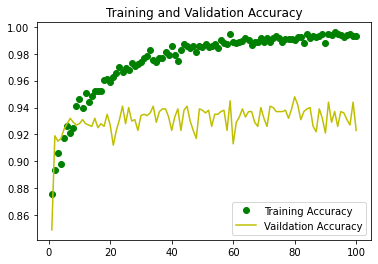

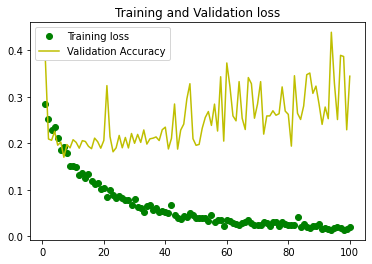

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(1, len(acc) + 1)

plt.plot(epoch, acc, 'go', label='Training Accuracy')
plt.plot(epoch, val_acc, 'y', label='Vaildation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epoch, loss, 'go', label='Training loss')
plt.plot(epoch, val_loss, 'y', label='Validation Accuracy')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### 코드 5-24 부드러운 그래프 그리기(지수 이동 평균)

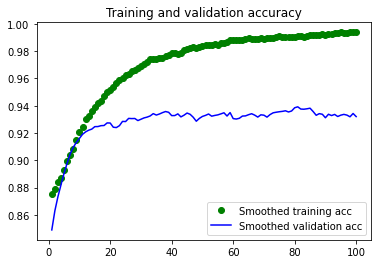

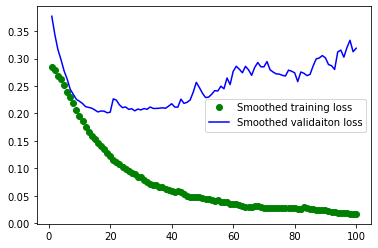

In [43]:
def smoothed_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epoch, smoothed_curve(acc), 'go', label='Smoothed training acc')
plt.plot(epoch, smoothed_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch, smoothed_curve(loss), 'go', label='Smoothed training loss')
plt.plot(epoch, smoothed_curve(val_loss), 'b', label='Smoothed validaiton loss')
plt.legend()

plt.show()

In [44]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size=20,
    class_mode = 'binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

Found 1000 images belonging to 2 classes.
test acc:  0.9399999976158142
